# Exercise 4: ML - Grundlagen und Algorithmen

## 0.) Reminders
Please adhere to the hand-in conventions specified in the 0-th exercise sheet, i.p.,
- You have to **submit the jupyter notebook file as well as the PDF**! 
- Please **adhere to the zip naming conventions**!


## Bayesian Learning
We start by loading our regression data set for the exercises on Bayesian learning.

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

np.random.seed(0)

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_plot = np.load('x_plot.npy')
y_plot = np.load('y_plot.npy')

# we assume the data noise standard deviation is known with a value of 1.0 
# thus, for this exercise, we fix the likelihood standard deviation sigma_y to 1.0
sigma_y = 1.0

## 1.) Bayesian Linear Regression (15 Points)

In this exercise we will implement Bayesian linear regression (BLR). 

### Exercise 1.1) Radial Basis Function Features (3 Points)
We will use radial basis function (RBF) features in this exercise. Remember the definition of the *RBF feature function*,
$$
\phi_i(\boldsymbol{x}):=\exp\left(-\dfrac{||\boldsymbol{x}-\boldsymbol{\mu}_i||^2}{2\sigma^2}\right), \quad i\in \left\{1, \dots, k \right\}, \quad \phi_0(\boldsymbol{x}) := 1, \quad \boldsymbol{x}, \boldsymbol{\mu_i} \in \mathbb R^d, \sigma \in \mathbb R.
$$
Here, all features share the same variance ("bandwith") $\sigma^2$ and we define the $i$-th feature to have mean $\boldsymbol{\mu}_i$. Do not confuse $\sigma^2$, the bandwith of the RBF kernel, with the likelihood variance $\sigma_y^2$, which we fixed above. The $0$-th feature is the bias. 

We define the *feature vector* as 
$$
\boldsymbol{\phi}(\boldsymbol{x}) := \left(\phi_0(\boldsymbol{x}), \phi_1 (\boldsymbol{x}), \dots, \phi_k (\boldsymbol{x}) \right)^T \in \mathbb R^{k+1}.
$$

Given training inputs $\boldsymbol X = \left\{\boldsymbol{x}_1, \dots, \boldsymbol{x}_N\right\}$, $\boldsymbol{x}_i \in \mathbb R^d$, we define the *feature matrix* as:
$$
\boldsymbol{\Phi}(\boldsymbol X) := 
\begin{pmatrix}
 \boldsymbol{\phi}(\boldsymbol{x}_1)^T \\
    \vdots \\
 \boldsymbol{\phi}(\boldsymbol{x}_N)^T \\
\end{pmatrix} =
\begin{pmatrix}
 \phi_0(\boldsymbol{x}_1) &\phi_1(\boldsymbol{x}_1) & \phi_2(\boldsymbol{x}_1) &...& \phi_k(\boldsymbol{x}_1) \\
    \vdots &\vdots &\vdots &\vdots &\vdots\\
  \phi_0(\boldsymbol{x}_N) &\phi_1(\boldsymbol{x}_N) & \phi_2(\boldsymbol{x}_N) &...& \phi_k(\boldsymbol{x}_N) \\
\end{pmatrix}.
$$

Implement the following function, which is supposed to return the RBF feature matrix.

**Hint**: As always, do not use any for-loops!

In [34]:
def rbf_feature_matrix(x: np.ndarray, means: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param x: inputs (shape: [N, d])
    :param means: means of the RBF features (shape: [k, d])
    :param sigma: bandwidth parameter of the RBF features (shape: scalar)
    :return: the RBF feature matrix (shape: [N, k+1])
    """
    if len(x.shape) == 1:
        x = x.reshape((-1, 1))

    if len(means.shape) == 1:
        means = means.reshape((-1, 1))

    ############################################################
    # TODO Implement the RBF features
    dist = np.linalg.norm(x[:, np.newaxis] - means, axis=-1)
    features = np.exp(-0.5 * (dist / sigma) ** 2)
    features = np.hstack((features, np.ones((features.shape[0], 1))))
    ############################################################
    
    assert features.shape == (x.shape[0], means.shape[0]+1)
    return features

In this exercise we fix the number $k$ of RBF features as well as their means $\boldsymbol{\mu}_i$.

In [35]:
# we use a fixed number of k = 5 RBF features
k = 5 
# we spread the centers of the RBF over the range of x_plot
feature_means = np.linspace(np.min(x_plot), np.max(x_plot), k)   

Let us visualize the features:

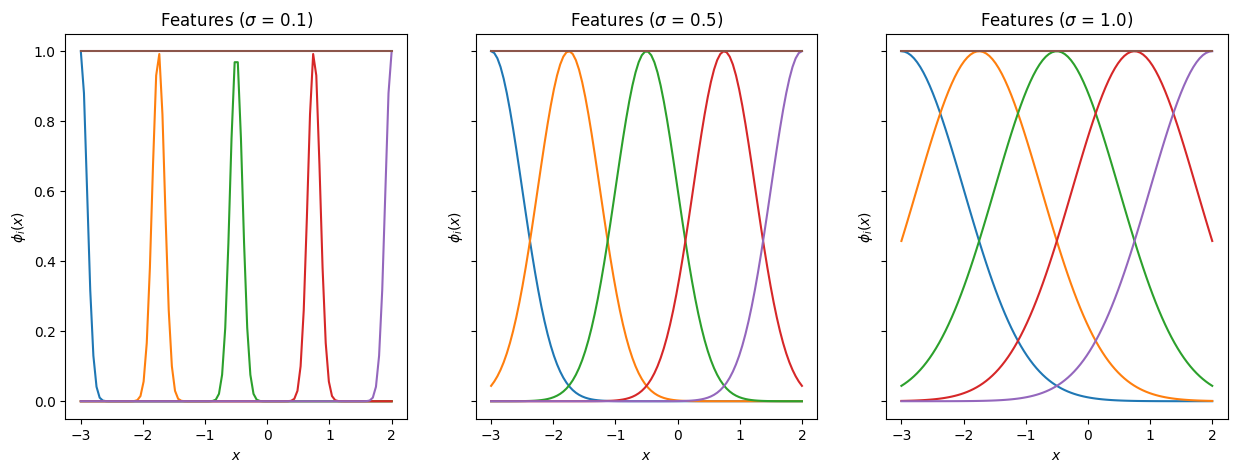

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,5))
feature_sigmas = [0.1, 0.5, 1.0]
features = [rbf_feature_matrix(x=x_plot, means=feature_means, sigma=feature_sigma) for feature_sigma in feature_sigmas]
for ax, feature, feature_sigma in zip(axes, features, feature_sigmas):
    ax.plot(x_plot, feature[:, :])
    ax.set_title(f"Features ($\sigma$ = {feature_sigma})")
    _ = ax.set_xlabel("$x$")
    _ = ax.set_ylabel("$\phi_i(x)$")

### Exercise 1.2) Posterior Distribution (3 Points)

Now we will implement the posterior distribution of the parameters for BLR. Recall that in the case of a Gaussian prior and a Gaussian likelihood, the posterior distribution is again Gaussian. In the lecture, we derived the closed form solution for the posterior mean and covariance parameters for a zero-mean prior with isotropic precision $\lambda$:
$$
\boldsymbol \mu_{\boldsymbol w | \boldsymbol X, \boldsymbol{y}} = \left( \boldsymbol{\Phi}(\boldsymbol{X})^T \boldsymbol{\Phi}(\boldsymbol{X}) + \sigma_y^2 \lambda \boldsymbol I \right)^{\,\,-1} \boldsymbol{\Phi}(\boldsymbol{X})^T \boldsymbol{y}, \quad \boldsymbol \Sigma_{\boldsymbol w | \boldsymbol X, \boldsymbol y} = \sigma_y^2 \left(\boldsymbol{\Phi}(\boldsymbol{X})^T \boldsymbol{\Phi}(\boldsymbol{X}) + \sigma_y^2 \lambda \boldsymbol{I} \right)^{\,\,-1}
$$
where $\boldsymbol{y} := \left(y_1, \dots, y_N \right)^T$ are the targets corresponding to $\boldsymbol X$ and $\sigma_y^2$ is the variance of the likelihood.

Implement the following function, which should return the posterior mean and the posterior covariance using RBF features.

**Hints:** 
- We defined the likelihood variance $\sigma_y^2$ as a global variable at the beginning of this notebook and fixed it to the true noise variance of 1.0, which we assume to be known for this exercise. 
- Avoid unneccessary computations, and use numerically stable operations instead of computing inverses, whenever possible!

In [37]:
def blr_posterior_distribution(X: np.ndarray, y: np.ndarray, lam: float, means: np.ndarray, sigma: float):
    """
    :param X: training inputs (shape: [N, d])
    :param y: training targets (shape: [N, 1])    
    :param lam: prior precision (scalar)
    :param means: means of the RBF features (shape: [k, d])
    :param sigma: bandwidth of the RBF features (scalar)
    :return: posterior mean (shape: [k+1])
             posterior covariance (shape: [k+1, k+1]) 
    """
    if len(y.shape) == 1:
        y = y.reshape((-1, 1))
        
    ############################################################
    # TODO Implement the posterior distribution
    Phi = rbf_feature_matrix(X, means, sigma)
    inv_term = np.linalg.inv(np.dot(Phi.T, Phi) + lam * np.eye(Phi.shape[1]))
    post_mean = np.dot(inv_term, np.dot(Phi.T, y)).squeeze()
    post_cov = sigma**2 * inv_term
    ############################################################
    assert post_mean.shape == (means.shape[0]+1,)
    assert post_cov.shape == (means.shape[0]+1, means.shape[0]+1)
    return post_mean, post_cov

### Exercise 1.3) Predictive Distribution (3 Points)
Now, we will implement the BLR predictive distribution. From the lecture, we know the predictive mean and variance at a query input $\boldsymbol{x}^* \in \mathbb R^d$ are given analytically as:
$$
\mu\left(\boldsymbol{x}^* \right) = \boldsymbol{\phi}\left(\boldsymbol{x}^*\right)^T \left( \boldsymbol{\Phi}(\boldsymbol{X})^T \boldsymbol{\Phi}(\boldsymbol{X}) + \sigma_y^2 \lambda \boldsymbol I \right)^{\,\,-1} \boldsymbol{\Phi}(\boldsymbol{X})^T \boldsymbol{y}, \quad \sigma^2\left(\boldsymbol{x}^* \right) = \sigma^2_y + \sigma^2_y \boldsymbol{\phi}\left(\boldsymbol{x}^*\right)^T \left( \boldsymbol{\Phi}(\boldsymbol{X})^T \boldsymbol{\Phi}(\boldsymbol{X}) + \sigma_y^2 \lambda \boldsymbol I \right)^{\,\,-1} \boldsymbol{\phi}\left(\boldsymbol{x}^*\right).
$$

Implement the following function, which should return the predictive mean and the predictive variance using RBF features.

**Hints:** 
- We defined the likelihood variance $\sigma_y^2$ as a global variable at the beginning of this notebook and fixed it to the true noise variance of 1.0, which we assume to be known for this exercise. 
- Avoid unneccessary computations, and use numerically stable operations instead of computing inverses, whenever possible!
- You can re-use `rbf_feature_matrix` to compute the feature vector at the query inputs.
- Do not use any for loops!

In [38]:
def blr_predictive_distribution(x: np.ndarray, X: np.ndarray, y: np.ndarray, lam: float, means: np.ndarray, sigma: float):
    """"
    :param x: query inputs (shape: [N_q, d])
    :param X: training inputs (shape: [N, d])
    :param y: training targets (shape: [N, 1])    
    :param lam: prior precision (scalar)
    :param means: means of the RBF features (shape: [k, d])
    :param sigma: bandwidth of the RBF features (scalar)
    :return: the predictive mean (shape: [N_q])
             the predictive variance (shape: [N_q])
    """
    ############################################################
    # TODO Implement the predictive distribution
    Phi_X = rbf_feature_matrix(X, means, sigma)
    Phi_x = rbf_feature_matrix(x, means, sigma)
    inv_term = np.linalg.inv(np.dot(Phi_X.T, Phi_X) + lam * np.eye(Phi_X.shape[1]))
    mean_x = np.dot(Phi_x, np.dot(inv_term, np.dot(Phi_X.T, y))).squeeze()
    var_x = sigma**2 + np.diagonal(np.dot(Phi_x, np.dot(inv_term, Phi_x.T)))
    ############################################################
    assert mean_x.shape == (x.shape[0],)
    assert var_x.shape == (x.shape[0],)    
    return mean_x, var_x

### Exercise 1.4) Sample Functions (3 Points)
We now implement a function to compute function samples, i.e., functions generated by models sampled from the BLR posterior distribution. We want to return $S$ function samples in one function call.

**Hints**:
- Given the training data, first compute the posterior distribution over parameters.
- Sample from this posterior distribution a set of $S$ weight vectors. Use the appropriate function from `np.random`. 
- Transform the sampled weight vectors to function evaluations at the query inputs. You already know how to do that from our discussion of standard linear regression.
- As always, for-loops are not allowed! `np.random` allows batched sampling!

In [39]:
def blr_sample_function(x: np.ndarray, X: np.ndarray, y: np.ndarray, lam: float, means: np.ndarray, sigma: float, S: int):
    """
    :param x: query inputs (shape: [N_q, d])
    :param X: training inputs (shape: [N, d])
    :param y: training targets (shape: [N, 1])    
    :param lam: prior precision (scalar)
    :param means: means of the RBF features (shape: [k, d])
    :param sigma: bandwidth of the RBF features (scalar)
    :param S: number of sample functions to generate (integer) 
    :return: the predictions at the inputs for S sampled models (shape: [S, N_q])
    """
    ############################################################
    # TODO Implement the computation of S function samples, evaluated at x
    Phi_x = rbf_feature_matrix(x, means, sigma)
    post_mean, post_cov = blr_posterior_distribution(X, y, lam, means, sigma)
    weight_samples = np.random.multivariate_normal(post_mean, post_cov, size=S)
    predictions = np.dot(Phi_x, weight_samples.T).T
    ############################################################
    assert predictions.shape == (S, x.shape[0])
    return predictions

Let us now plot some sampled functions and the predictive distribution for different values of the hyperparameters $\lambda$ and $\sigma$.

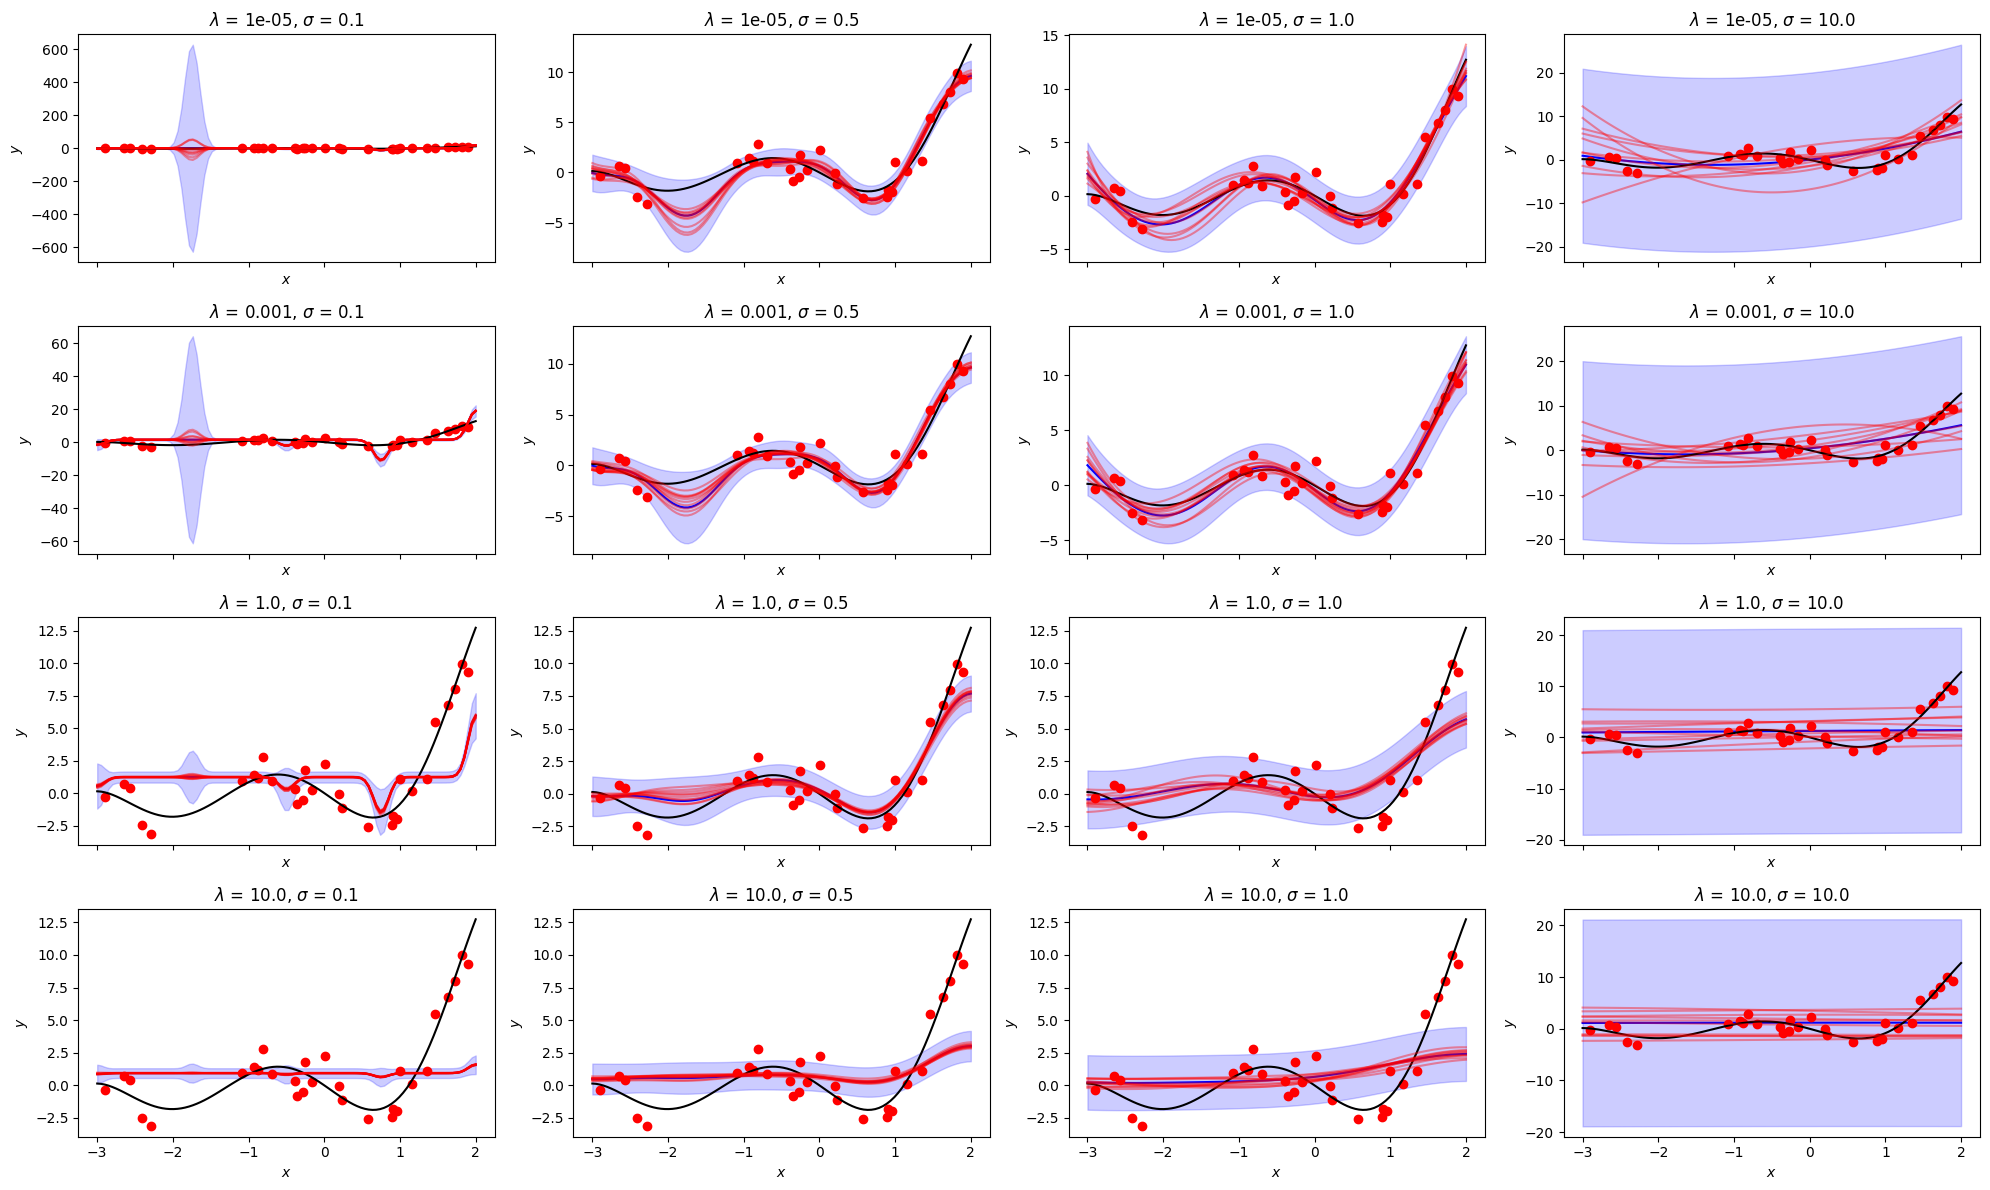

In [40]:
# define lambdas and sigmas
lambdas = [1e-5, 1e-3, 1.0, 10.0]
feature_sigmas = [0.1, 0.5, 1.0, 10.0]

# compute predictive distribution and function samples for the lambdas and sigmas
pred_means, pred_vars, funcss, labels = [], [], [], []
for lam, feature_sigma in product(lambdas, feature_sigmas):
    # obtain the predictive distribution
    pred_mean, pred_var = blr_predictive_distribution(x=x_plot, X=x_train, y=y_train, lam=lam, 
                                                      means=feature_means, sigma=feature_sigma)

    # obtain 10 sample functions
    funcs = blr_sample_function(x=x_plot, X=x_train, y=y_train, lam=lam, 
                                means=feature_means, sigma=feature_sigma, S=10)
        
    # collect computed stuff
    pred_means.append(pred_mean)
    pred_vars.append(pred_var)
    funcss.append(funcs)
    labels.append(f"$\lambda$ = {lam}, $\sigma$ = {feature_sigma}")
    

# plot 
fig, axes = plt.subplots(nrows=len(lambdas), ncols=len(feature_sigmas), sharex=True, figsize=(len(feature_sigmas)*5, len(lambdas)*3), squeeze=False)
for i, (pred_mean, pred_var, funcs, label) in enumerate(zip(pred_means, pred_vars, funcss, labels)):
    ax = axes[i//len(feature_sigmas), i%len(feature_sigmas)]
    
    # the predictive distribution together with the 95% confidence interval
    ax.plot(x_plot, pred_mean, 'b', label=label)
    ax.fill_between(np.squeeze(x_plot), np.squeeze(pred_mean)-2*np.sqrt(pred_var), 
                    np.squeeze(pred_mean)+2*np.sqrt(pred_var), alpha=0.2, color='blue')
    ax.plot(x_train, y_train, 'or')
    ax.plot(x_plot, y_plot, 'black')
    
    for i in range(funcs.shape[0]):
        # plot function samples
        ax.plot(x_plot, funcs[i], 'red', alpha=0.4)
    
    ax.set_title(label)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
fig.tight_layout()


### Exercise 1.5) Discussion (3 Points)
In the plots above we visualized the predictive distribution and sample functions of BLR for different values of the hyperparameters $\lambda$ and $\sigma$. 

- Discuss how the predictive distribution/sample functions change in dependence of these hyperparameters. Explain why this is the case!

- Assume you only had access to `blr_sample_function` but not to `blr_predictive_distribution`. How could you approximate the parameters of the predictive distribution using only function samples?

#TODO:

## 2.) Gaussian Processes (5 Points)
In this exercise, we will study the kernelized version of BLR, the Gaussian Process (GP). We will apply GPs on the same data set as before.

### Exercise 2.1) Gaussian Kernel (2 Points)
Recall that for BLR we worked with a fixed set of features. In contrast, for GPs we define a discrepancy measure between input points, the so-called kernel function $k$, which by means of the kernel trick implicitly defines a (possibly infinite-dimensional) set of features. As we never have to explicitly evaluate these implicit features, we can work in very expressive feature spaces and still obtain a tractable algorithm. 

In the lecture, we defined the Gaussian kernel function as
$$
k(\boldsymbol{x}, \boldsymbol{x}') := \lambda^{-1} \exp\left(-\dfrac{||\boldsymbol{x}-\boldsymbol{x}'||^2}{2\sigma^2}\right), \quad \boldsymbol{x}, \boldsymbol{x'} \in \mathbb R^d,
$$
where $\lambda$ denotes the prior precision parameter and $\sigma^2$ is the kernel bandwidth.

Furthmerore, given training inputs $\boldsymbol X = \left\{\boldsymbol{x}_1, \dots, \boldsymbol{x}_N\right\}$, $\boldsymbol{x}_i \in \mathbb R^d$, we defined the kernel vector as 
$$
\boldsymbol{k}(\boldsymbol{x}) := \left(k(\boldsymbol{x}_1, \boldsymbol{x}), \dots, k(\boldsymbol{x}_N, \boldsymbol{x}) \right)^T.
$$
Note that the dimension of the kernel vector is now determined by the number $N$ of training examples. In contrast, for BLR, the dimension of the feature vector $k$ was a fixed constant. We already discussed this distinction (parametric vs. non-parametric/instance-based methods) a number of times in the lecture.

Finally, we define the *kernel matrix* as
$$
\boldsymbol K := 
\begin{pmatrix}
  \boldsymbol{k}(\boldsymbol{x}_1) &  \dots & \boldsymbol{k}(\boldsymbol{x}_N)
\end{pmatrix} =
\begin{pmatrix}
  k(\boldsymbol{x}_1, \boldsymbol{x}_1) & \dots & k(\boldsymbol{x}_1, \boldsymbol{x}_N) \\
  \vdots & \vdots & \vdots \\
  k(\boldsymbol{x}_N, \boldsymbol{x}_1) & \dots & k(\boldsymbol{x}_N, \boldsymbol{x}_N) \\
\end{pmatrix}.
$$

Implement the Gaussian kernel vector.

**Hints**:
- Note that you are supposed to compute the kernels for a batch of inputs $\boldsymbol{x}$ and for a batch of inputs $\boldsymbol{x'}$ in one function call.
- As always, no for-loops are allowed!

In [41]:
def gaussian_kernel(x: np.ndarray, x_prime: np.ndarray, lam: float, sigma: float) -> np.ndarray:
    """
    :param x: first input (shape: [N_1, d])
    :param x_prime: second input (shape: [N_2 x d])
    :param lam: prior precision parameter (scalar)
    :param sigma: bandwidth of the kernel (scalar)
    :return: the Gaussian kernel, evaluated at all pairs (x, x') (shape: [N_1 x N_2])
    """
    if len(x.shape) == 1:
        x = x.reshape((-1, 1))
        
    if len(x_prime.shape) == 1:
        x_prime = x_prime.reshape((-1, 1))
        
    ############################################################
    # TODO Implement the Gaussian kernel
    dist_squared = np.sum((x[:, None] - x_prime[None, :]) ** 2, axis=-1)
    kernel = lam ** (-1) * np.exp(-dist_squared / (2 * sigma ** 2))
    ############################################################
    
    assert kernel.shape == (x.shape[0], x_prime.shape[0])
    return kernel

Using `gaussian_kernel`, we can now easily compute the Gaussian kernel matrix. You do not need to implement anything here.

In [42]:
def gaussian_kernel_matrix(X: np.ndarray, lam: float, sigma: float) -> np.ndarray:
    """
    :param X: training data (shape: [N, d])
    :param lam: prior precision parameter (scalar)
    :param sigma: bandwidth of the kernel (scalar)
    :return: the kernel matrix (N_train x N_train)
    """
    return gaussian_kernel(x=X, x_prime=X, lam=lam, sigma=sigma)

### Exercise 2.2) Predictive Distribution for GPs (2 Points)
From the lecture, we know the predictive mean and variance at a query input $\boldsymbol{x}^* \in \mathbb R^d$ for GPs read:
$$
\mu(\boldsymbol{x}^*) = \boldsymbol{k}(\boldsymbol{x}^*)^T \left(\boldsymbol K + \sigma_y^2 \boldsymbol I \right)^{-1} \boldsymbol y, \quad \sigma(\boldsymbol{x}^*) = \sigma_y^2 + k(\boldsymbol{x}^*, \boldsymbol{x}^*) - \boldsymbol{k}(\boldsymbol{x}^*)^T \left(\boldsymbol K + \sigma_y^2 \boldsymbol I \right)^{-1} \boldsymbol{k}(\boldsymbol{x}^*),
$$
where $\boldsymbol{y} := \left(y_1, \dots, y_N \right)^T$ are the targets corresponding to $\boldsymbol X$ and $\sigma_y^2$ is the variance of the likelihood.

Implement the predictive distribution for GPs.

**Hints:** 
- We defined the likelihood variance $\sigma_y^2$ as a global variable at the beginning of this notebook and fixed it to the true noise variance of 1.0, which we assume to be known for this exercise. 
- Avoid duplicate or unneccessary computations, and use numerically stable operations instead of computing inverses, if possible!
- Make use of both `gaussian_kernel` and `gaussian_kernel_matrix`!
- Do not use any for loops!

In [54]:
def gp_predictive_distribution(x: np.ndarray, y: np.ndarray, X: np.ndarray, lam: float, sigma: float):
    """"
    :param x: query inputs (shape: [N_q, d])
    :param X: training inputs (shape: [N, d])
    :param y: training targets (shape: [N, 1])
    :param lam: prior precision parameter (scalar)
    :param sigma: bandwidth of the kernel (scalar)
    :return: the mean (shape: [N_q])
             the variance (shape: [N_q])
             of the predictive distribution
    """
    ############################################################
    # TODO Implement the predictive distribution for GPs
    K = gaussian_kernel_matrix(X, lam, sigma)
    k_x = gaussian_kernel(X, x, lam, sigma)
    mean_x = (k_x.T @ np.linalg.inv(K + sigma_y ** 2 * np.eye(K.shape[0])) @ y).squeeze()
    var_x = sigma_y ** 2 + np.diag(gaussian_kernel(x, x, lam, sigma)) - np.einsum('ij,ji->i', k_x.T @ np.linalg.inv(K + sigma_y ** 2 * np.eye(K.shape[0])), k_x)
    #var_x = sigma_y ** 2 + gaussian_kernel(x, x, lam, sigma) - k_x.T @ np.linalg.inv(K + sigma_y ** 2 * np.eye(K.shape[0])) @ k_x
    ############################################################
    print(var_x.shape , (x.shape[0],))
    assert mean_x.shape == (x.shape[0],)
    assert var_x.shape == (x.shape[0],)    
    return mean_x, var_x

Let us again plot the predictive distribution for different values of the hyperparameters.

(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)
(100,) (100,)


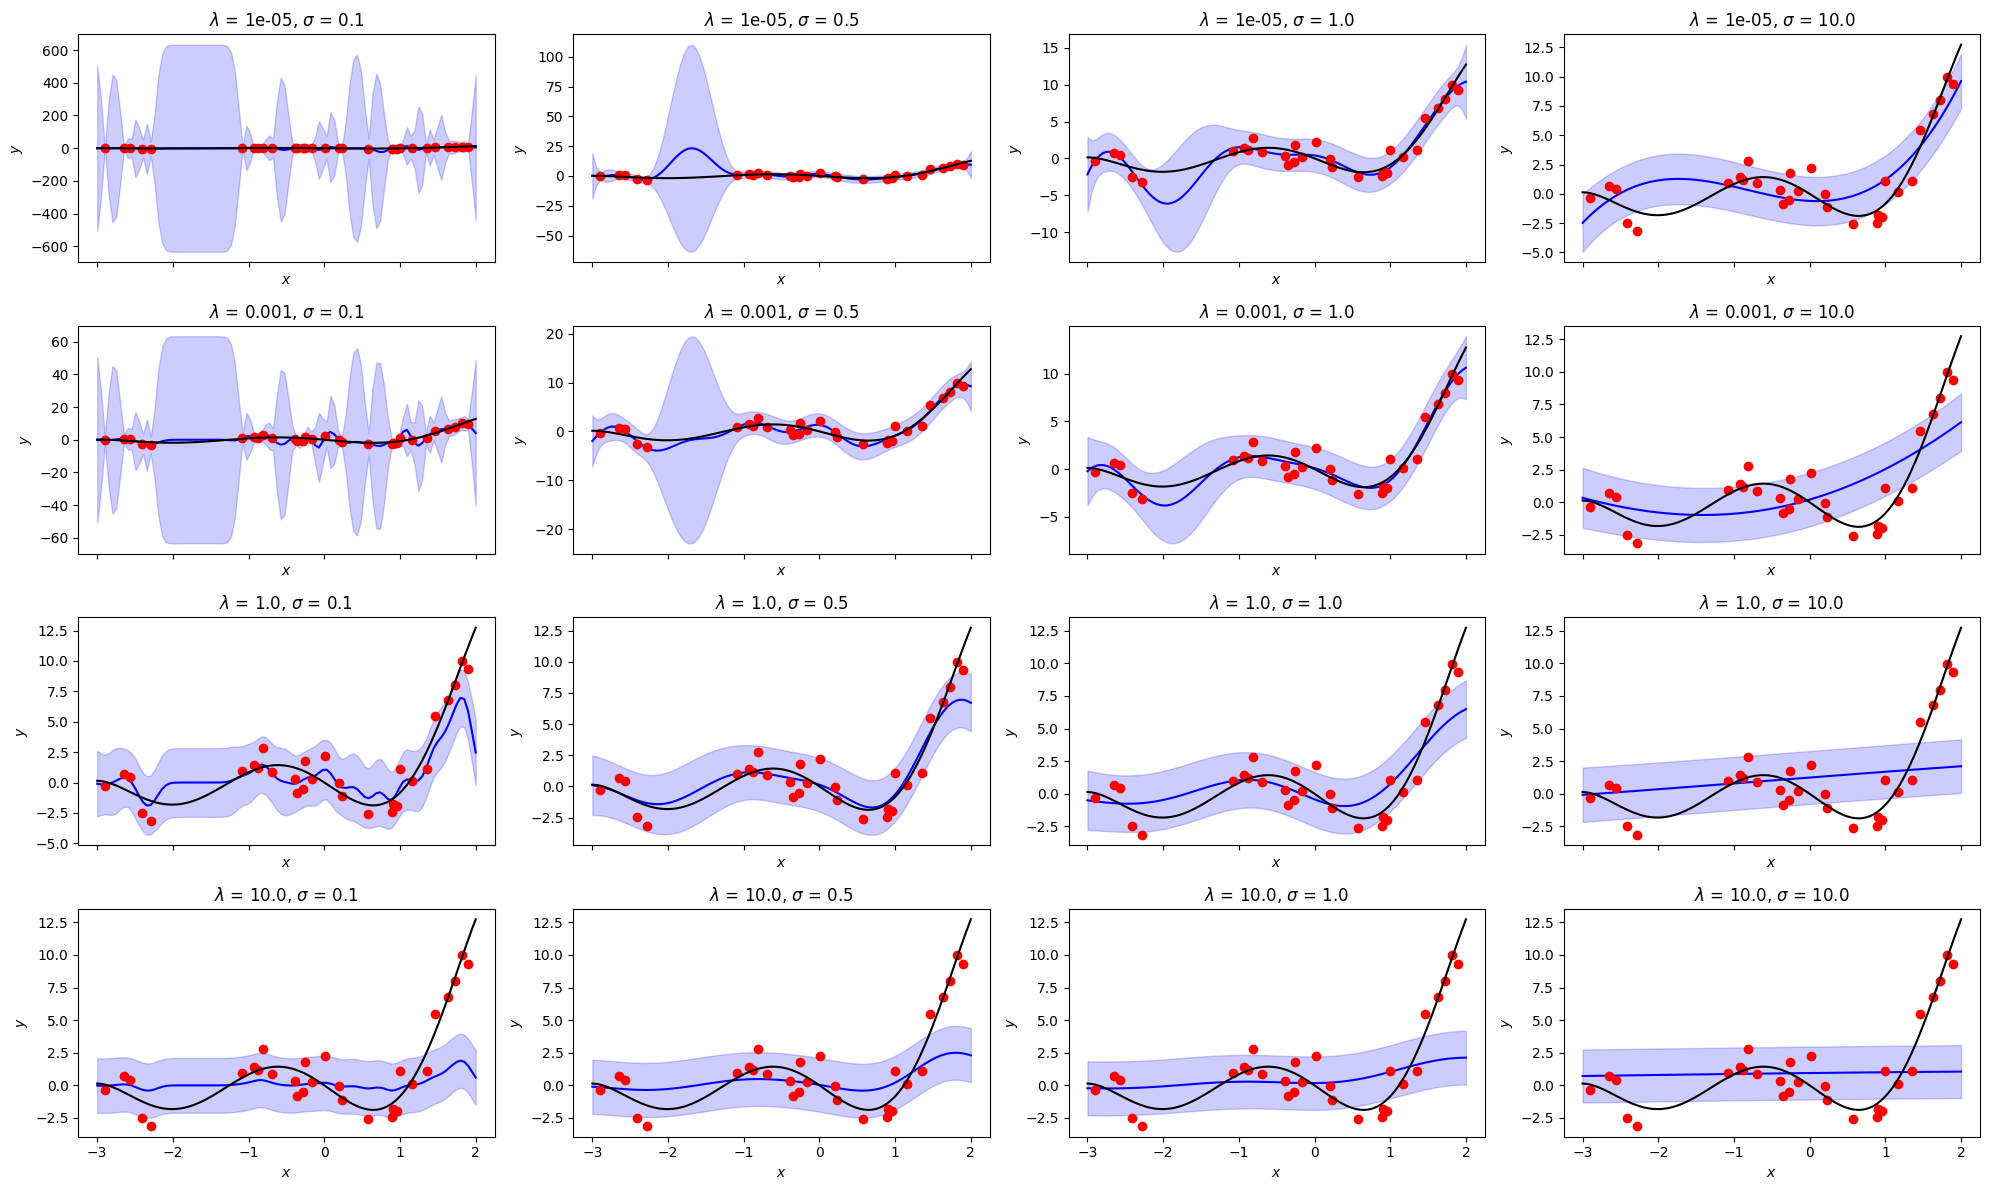

In [55]:
# define lambdas and sigmas
lambdas = [1e-5, 1e-3, 1.0, 10.0]
feature_sigmas = [0.1, 0.5, 1.0, 10.0]

# compute predictive distribution and function samples for the lambdas and sigmas
pred_means, pred_vars, labels = [], [], []
for lam, feature_sigma in product(lambdas, feature_sigmas):
    # obtain the predictive distribution
    pred_mean, pred_var = gp_predictive_distribution(x=x_plot, X=x_train, y=y_train, lam=lam, sigma=feature_sigma)
        
    # collect computed stuff
    pred_means.append(pred_mean)
    pred_vars.append(pred_var)
    labels.append(f"$\lambda$ = {lam}, $\sigma$ = {feature_sigma}")
    

# plot 
fig, axes = plt.subplots(nrows=len(lambdas), ncols=len(feature_sigmas), sharex=True, figsize=(len(feature_sigmas)*5, len(lambdas)*3), squeeze=False)
for i, (pred_mean, pred_var, funcs, label) in enumerate(zip(pred_means, pred_vars, funcss, labels)):
    ax = axes[i//len(feature_sigmas), i%len(feature_sigmas)]
    
    # the predictive distribution together with the 95% confidence interval
    ax.plot(x_plot, pred_mean, 'b', label=label)
    ax.fill_between(np.squeeze(x_plot), np.squeeze(pred_mean)-2*np.sqrt(pred_var), 
                    np.squeeze(pred_mean)+2*np.sqrt(pred_var), alpha=0.2, color='blue')
    ax.plot(x_train, y_train, 'or')
    ax.plot(x_plot, y_plot, 'black')
    
    ax.set_title(label)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
fig.tight_layout()

### Exercise 2.3) Sampling Functions from a GP (1 Point)
For BLR, we could obtain function samples, evaluated at query inputs, by sampling weights from the posterior and transforming them to function evaluations at the query inputs (cf. Exercise 1.4). Explain how this works for GPs! I.e., how we can obtain function samples, evaluated at query inputs, from GPs?

In [ ]:
#TODO: